# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8352 total dog images.


In [2]:
# I will also set some parameters here that will be helpful
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
img_short_side_resize = 256
img_input_size = 224
shuffle = True
num_workers = 16
batch_size = 64

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1
Size of faces is  (1, 4)


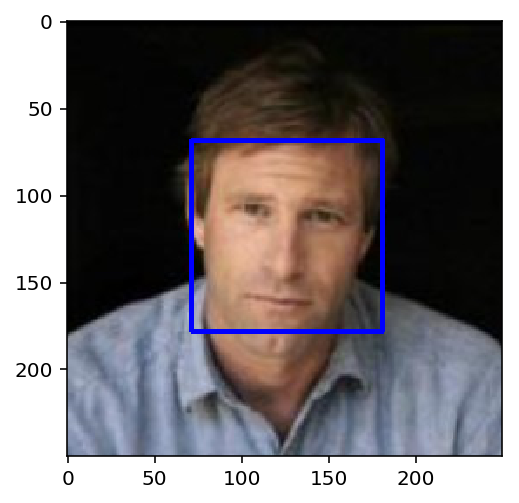

In [93]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               
%config InlineBackend.figure_format = 'retina'

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
print("Size of faces is ",faces.shape)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

- A human face was detected in 96% of the first 100 images in `human_files`.
- A human face was detected in 18% of the first 100 images in `dog_files`.

In [5]:
def detect_faces(img_paths):
    faces_detected = np.zeros(len(img_paths))
    for i in range(len(img_paths)):
        faces_detected[i] = face_detector(img_paths[i])
    return faces_detected, np.mean(faces_detected)*100 

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
faces_detected_human, percent_faces_human = detect_faces(human_files_short)
faces_detected_dog, percent_faces_dog = detect_faces(dog_files_short)

In [7]:
print(f"{percent_faces_human:.3f}% of human faces found")
print(f"{percent_faces_dog:.3f}% of dogs confused with humans")

96.000% of human faces found
18.000% of dogs confused with humans


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

With no "human" class in imagenet there is no straightforward way to detect human faces with the models included in PyTorch. With the data provided here we could train a model to distinguish humans from dogs, but that's not exactly what we want. We want to distinguish humans from **everything else**, which would mean using additional training data that was not provided. I decided not to pursue this path, especially since the true positive rate of the human face detector is pretty good. 

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [9]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
# I'm loading some other models to compare them with the VGG16
VGG16_bn = models.vgg16_bn(pretrained=True)
alexnet = models.alexnet(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
resnet152 = models.resnet152(pretrained=True)
inception_v3 = models.inception_v3(pretrained=True)

# All these models will be used in evaluation mode 
model_list = [alexnet.eval(),VGG16.eval(),VGG16_bn.eval(),resnet18.eval(),resnet152.eval(),inception_v3.eval()]
model_names = ["alexnet","VGG16","VGG16_bn","resnet18","resnet152","inception_v3"]

# check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")
    print("Using",torch.cuda.get_device_name(device))
    
VGG16 = VGG16.to(device)

CUDA is available!  Training on GPU ...
Using GeForce RTX 2070


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
def im_convert(tensor):
    """ Display a tensor as an image. """    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

def show_image_from_path(img_path, title = None):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if title is not None:
        plt.gca().set_title(title)
    plt.show()

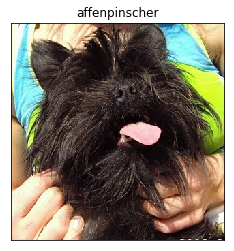

In [11]:
from PIL import Image
import torchvision.transforms as transforms
import json
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

def model_predict(img_path, model, device):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    ''' 
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path).convert('RGB')
    # To avoid changing the aspect ratio of the image we can use the FiveCrop transform, which returns the center and the 
    # corner crops. Five outputs are calculated and then averaged.
    in_transform = transforms.Compose([
                        transforms.Resize(img_short_side_resize),  
                        transforms.FiveCrop(img_input_size),
                        transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                    transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])        
    
    output = torch.argmax(model(in_transform(image).to(device)).mean(0))
   
    return output.to("cpu").item() # predicted class index


test_image = dog_files_short[0]
pred = model_predict(test_image, VGG16, device)
show_image_from_path(test_image, title = idx2label[pred])

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model, device):
    ## TODO: Complete the function.
    out = model_predict(img_path,model,device)
    return out >= 151 and out <= 268 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- A dog was detected in 0% of the images in `human_files_short`.
- A dog was detected in 93% of the images in `dog_files_short`.

In [13]:
# ### TODO: Test the performance of the dog_detector function
# ### on the images in human_files_short and dog_files_short.
# dogs_detected_correctly = [dog_detector(img_path,VGG16,device) for img_path in dog_files_short]
# dogs_detected_incorrectly = [dog_detector(img_path,VGG16,device) for img_path in human_files_short]

In [14]:
# tpr_vgg16 = np.mean(dogs_detected_correctly)
# fpr_vgg16 = np.mean(dogs_detected_incorrectly)

# print(f"VGG16: {fpr_vgg16 * 100:.3f}% of humans confused with dogs")
# print(f"VGG16: {tpr_vgg16 * 100:.3f}% dogs correctly identified")

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [15]:
# ### (Optional) 
# ### TODO: Report the performance of another pre-trained network.
# ### Feel free to use as many code cells as needed.

# VGG16 = VGG16.to("cpu")
# torch.cuda.empty_cache()
# tpr = np.zeros(len(model_list))
# fpr = np.zeros(len(model_list))
# for i in range(len(model_list)):
#     model = model_list[i].to(device)
#     tpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in dog_files_short])
#     fpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in human_files_short])
#     model = model.to("cpu")

In [16]:
# # Sort the tpr and fpr
# idx_tpr = np.argsort(tpr)[::-1]
# idx_fpr = np.argsort(fpr)

# fig,ax = plt.subplots(1,2,figsize = (18,4))
# ax[0].bar([model_names[i] for i in idx_tpr],tpr[idx_tpr])
# ax[0].set_title(f"Dog detection first 100 images: true positive rate high to low")
# ax[0].set_ylim((0.9,1))
# ax[1].bar([model_names[i] for i in idx_fpr],fpr[idx_fpr])
# ax[1].set_title("Dog detection first 100 images: false positive rate low to high")
# plt.show()

The above bar plot is very surprising: alexnet seems to be the best at detecting dogs, resnet18 the worst. But even more, a false positive rate of 0% for all networks except alexnet? This seems fishy. Let's take a look at the first 500 images and see if they paint a similar picture. 

In [17]:
# ### (Optional) 
# ### TODO: Report the performance of another pre-trained network.
# ### Feel free to use as many code cells as needed.

# VGG16 = VGG16.to("cpu")
# torch.cuda.empty_cache()
# tpr = np.zeros(len(model_list))
# fpr = np.zeros(len(model_list))
# for i in range(len(model_list)):
#     model = model_list[i].to(device)
#     tpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in dog_files[:500]])
#     fpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in human_files[:500]])
#     model = model.to("cpu")

In [18]:
# # Sort the tpr and fpr
# idx_tpr = np.argsort(tpr)[::-1]
# idx_fpr = np.argsort(fpr)

# fig,ax = plt.subplots(1,2,figsize = (18,4))
# ax[0].bar([model_names[i] for i in idx_tpr],tpr[idx_tpr])
# ax[0].set_title(f"Dog detection first 500 images: true positive rate high to low")
# ax[0].set_ylim((0.9,1))
# ax[1].bar([model_names[i] for i in idx_fpr],fpr[idx_fpr])
# ax[1].set_title("Dog detection first 500 images: false positive rate low to high")
# plt.show()

This is certainly unexpected. Alexnet has the highest true positive rate (i.e. proportion of dog images in which a dog is actually detected) but also the lowest false negative rate (proportion of human images in which a dog is detected). 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [19]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_input_size),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])

train_data = datasets.ImageFolder("./dogImages/train/",transform_train)
valid_data = datasets.ImageFolder("./dogImages/valid/",transform_test)
test_data = datasets.ImageFolder("./dogImages/test/",transform_test)
data = {"train" : train_data, "valid" : valid_data, "test" : test_data}
n_classes = len(train_data.classes)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(data["train"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=shuffle, pin_memory=True)
# If using the 5crop test time augmentation num_workers must be set to 0 otherwise we get an error. 
# The batch size during testing must also be reduced to keep memory requirements
valid_loader = torch.utils.data.DataLoader(data["valid"], batch_size=int(np.floor(batch_size/5)), 
                                           num_workers=0, shuffle=shuffle, pin_memory=True)
test_loader = torch.utils.data.DataLoader(data["test"], batch_size=int(np.floor(batch_size/5)), 
                                          num_workers=0, shuffle=shuffle, pin_memory=True)
loaders_scratch = {"train" : train_loader, "valid" : valid_loader, "test" : test_loader}   

In [20]:
# Now for the learning rate
learning_rates = 5e-4 * np.logspace(0,1.5,9)
learning_rate = learning_rates[2]

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- I chose a size of 224 x 224 for my input tensor, to make it easier to compare performance with pretrained models. 
- I've investigated the influence of augmentation techniques in the **from_scratch** notebook. I found that the most important data augmentation step is the RandomResizedCrop using **small** crops (more precisely a small number for the lower limit of the scale parameter). This might force the network to additionally learn other, less obvious patterns to distinguish breeds rather than the most obvious ones, since for each instance of the train set different inputs might be used each epoch. For example, a crop of the dog's head might be used in the first epoch, its tail in the second, and a picture of the whole dog in the third. Using small crops and then enlarging them should also make the resulting image blurrier, which might make the network more robust to differences in sharpness or focus. 
- I also found that resizing images and changing their aspect ratio is not beneficial for this dataset. By using RandomResizedCrop with a ratio of (1,1) we make sure that the aspect ratio does not change during training. We also want to keep the aspect ratio during validation/testing but we can't risk using only a small crop of the picture for inference. That's why I'm using the __[FiveCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.FiveCrop)__ transform to split the image in five crops (corners and center). The scores are then averaged across the crops. 
- Rotations did not seem to be beneficial either, as they led to slower training and higher validation loss. 
- I'm using horizontal flips because they make sense in this scenario: dogs can be facing the left or the right side of the picture, but they won't be upside down so we don't need vertical flips. The color jitter transform is useful since it can make the network more robust to differences in photo quality, such as contrast, exposure, and white balance. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes, depth_1 = 32):
        super(Net, self).__init__()        
        # Keep track of things
        depth_2 = depth_1 * 2
        depth_3 = depth_2 * 2      
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Conv set 1
        self.conv1_1 = nn.Conv2d(3,depth_1,3,stride = 1,padding = 1)
        self.conv1_2 = nn.Conv2d(depth_1,depth_1,3,stride = 1,padding = 1)
        self.bn1_1 = nn.BatchNorm2d(depth_1)
        self.bn1_2 = nn.BatchNorm2d(depth_1)
        # Conv set 2
        self.conv2_1 = nn.Conv2d(depth_1,depth_2,3,stride = 1,padding = 1)
        self.conv2_2 = nn.Conv2d(depth_2,depth_2,3,stride = 1,padding = 1)
        self.bn2_1 = nn.BatchNorm2d(depth_2)
        self.bn2_2 = nn.BatchNorm2d(depth_2)        
        # Conv set 3
        self.conv3_1 = nn.Conv2d(depth_2,depth_3,3,stride = 1,padding = 1)
        self.conv3_2 = nn.Conv2d(depth_3,depth_3,3,stride = 1,padding = 1)
        self.bn3_1 = nn.BatchNorm2d(depth_3)
        self.bn3_2 = nn.BatchNorm2d(depth_3)
        # Output
        self.fc_out = nn.Linear(depth_3,n_classes)   
        # Initialize weights
        nn.init.kaiming_normal_(self.conv1_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv1_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_2.weight, nonlinearity='relu') 
            
    def forward(self, x):
        # Conv 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)
        # Conv 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)
        # Conv 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)
        # First we fuse the height and width dimensions (2 and 3) 
        x = x.view(x.size(0),x.size(1),-1)        
        # And now max global pooling
        x = x.max(2)[0]
        # Output
        x = self.fc_out(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net(n_classes)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

A detailed guide to the architecture and the augmentation used here can be found in the **from_scratch** notebook. In short, the architecture is inspired by the __[VGG](https://arxiv.org/abs/1409.1556)__ networks, having three sets of two convolutional layers, each of them followed by max pooling. The initial depth of 32 is doubled after each max pool to preserve computational cost. Unlike VGG networks, the network above replaces the fully connected layers at the end with global **max** pooling. 

To the best of my knowledge, most popular architectures use global **average** pooling: the mean value (over the height and width dimensions) is calculated for each filter belonging to the last convolutional layer, with the resulting vector directly fed into the output layer. I believe this contradicts the philosophy of convolutional nets: we are interested in the "pattern detected" message and we don't want to dillute it with *lacks* of detection. This is why all spatial locations within a filter share weights and this is why we use the regular form of max pooling on the output of convolutions: we want to detect a relevant pattern wherever in the image it might be. A better way would be to use global **max** pooling, in which we take the maximum over the width and height dimensions of each filter. In the **from_scratch** notebook I show that global max pooling significantly outperforms global average pooling. Therefore I use it here as well. 

In the **from_scratch** notebook I also show the advantages of __[Kaiming initialization](https://arxiv.org/abs/1502.01852)__ and __[batch normalization](https://arxiv.org/abs/1502.03167)__. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(),learning_rate) 

### Let's add a learning rate scheduler
scheduler_scratch = ReduceLROnPlateau(optimizer_scratch, 'min', verbose = True, factor = 0.5, patience = 7)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [23]:
import time

def train_epoch(model,train_loader,optimizer,criterion,device):
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move to GPU
        data, target = data.to(device), target.to(device)
        # Set gradients to 0
        optimizer.zero_grad()
        # Get output
        output = model(data)               
        # Calculate loss
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)
        # Calculate gradients
        loss.backward()
        # Take step
        optimizer.step()    
    train_loss = train_loss / len(train_loader.dataset)
    return model, train_loss
        
def valid_epoch(model,valid_loader,criterion,device,fivecrop):
    ######################    
    # validate the model #
    ######################
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move to GPU
            data, target = data.to(device), target.to(device)
            # if we do test time augmentation with 5crop we'll have an extra dimension in our tensor
            if fivecrop == "mean":
                bs, ncrops, c, h, w = data.size()
                output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
                output = output.view(bs, ncrops, -1).mean(1)
            elif fivecrop == "max":
                bs, ncrops, c, h, w = data.size()
                output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
                output = output.view(bs, ncrops, -1).max(1)[0]
            else:
                output = model(data)
            ## update the average validation loss
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
    valid_loss = valid_loss / len(valid_loader.dataset) 
    return valid_loss

def train(n_epochs, loaders, model, optimizer, criterion, device, path_model, fivecrop = None, lr_scheduler = None):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_loss = []
    valid_loss = []
    # Time everything
    time_start = time.time()
    for epoch in range(1, n_epochs+1):
        time_start_epoch = time.time()    
        # Train this epoch
        model, train_loss_epoch = train_epoch(model,loaders["train"],optimizer,criterion,device)
        train_loss.append(train_loss_epoch)   
        # Validate this epoch
        valid_loss_epoch = valid_epoch(model,loaders["valid"],criterion,device,fivecrop)
        # Call the learning rate scheduler if we have one
        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss_epoch)
        valid_loss.append(valid_loss_epoch)  
        # Save if validation loss is the lowest so far
        if valid_loss_epoch <= valid_loss_min:
            torch.save(model.state_dict(), path_model)
            valid_loss_min = valid_loss_epoch 
        # Print epoch statistics
        print('Epoch {} done in {:.2f} seconds. \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
            epoch,             
            time.time() - time_start_epoch,
            train_loss_epoch,
            valid_loss_epoch
            ))   
    # Show final statistics    
    print(f"{n_epochs} epochs ready in {(time.time() - time_start):.3f} seconds. Minimum validation loss: {valid_loss_min:.3f}")
    # Load best config
    model.load_state_dict(torch.load(path_model))
    return model

# train the model
# model_scratch = train(3, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, 
#                       device, 'model_scratch.pt', fivecrop = "mean", lr_scheduler = scheduler_scratch)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, device):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            data, target = data.to(device), target.to(device)
            bs, ncrops, c, h, w = data.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
            output = output.view(bs, ncrops, -1).mean(1)        
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
# test(loaders_scratch, model_scratch, criterion_scratch, device)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [25]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [26]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

In [27]:
# Freezing all parameters
for param in model_transfer.parameters():
    param.requires_grad = False

In [28]:
# Replacing the last layer (by default it will have requires_grad == True)
model_transfer.fc = nn.Linear(model_transfer.fc.in_features,n_classes)
# Initialize the weights of the new layer
nn.init.kaiming_normal_(model_transfer.fc.weight, nonlinearity='relu')
# Transfer to GPU 
model_transfer = model_transfer.to(device)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

__[Resnet](https://arxiv.org/abs/1512.03385)__ is a powerful architecture that basically won all major image competitions in 2015. Batch normalization allows the network to train faster, residual connections allow it to be deeper than previous architectures, and replacing the fully connected layers with global average pooling means it does all this while having fewer parameters to train than VGG16. A pretrained residual network is a formidable feature extractor. Furthermore, it's easy to use it for transfer learning, as only the final linear layer needs to be replaced. I am also using the __[Kaiming initialization](https://arxiv.org/abs/1502.01852)__ here which proved to be highly recommended in the **from_scratch** notebook. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [29]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(),3e-4) 
scheduler_transfer = ReduceLROnPlateau(optimizer_transfer, 'min', verbose = True, factor = 0.5, patience = 7)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [30]:
# train the model
# model_transfer = train(100, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, 
#                        device, 'model_transfer.pt', fivecrop = "mean", lr_scheduler = scheduler_transfer)


# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [31]:
test(loaders_transfer, model_transfer, criterion_transfer, device)

Test Loss: 0.394815


Test Accuracy: 88% (736/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

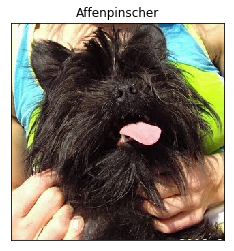

In [81]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data['train'].classes]

def predict_breed_transfer(img_path, model, device):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    
    # Resnet replaces the fully connected layer with global average pooling. Theoretically then, it should work with any 
    # input size, since the result of the global pooling depends only on the number of filters and not on their spatial 
    # dimensions. Unfortunately, the provided torchvision model implements global pooling as a regular average pooling
    # in which the kernel size is equal to the spatial size of the filters (in this case 7). So we still need to apply the
    # FiveCrop transform if we want to keep the aspect ratio and not only crop the center.
    
    in_transform = transforms.Compose([
                        transforms.Resize(img_short_side_resize),  
                        transforms.FiveCrop(img_input_size),
                        transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                    transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])        
    
    scores = model(in_transform(image).to(device)).mean(0)
    output = torch.argmax(scores)
   
    return output.to("cpu").item(), F.softmax(scores,dim=0).to("cpu").data.numpy() # predicted class index

test_image = dog_files_short[0]
pred,probs = predict_breed_transfer(test_image, model_transfer, device)
show_image_from_path(test_image, title = class_names[pred])

In [88]:
sum(probs)

1.0000000561991322

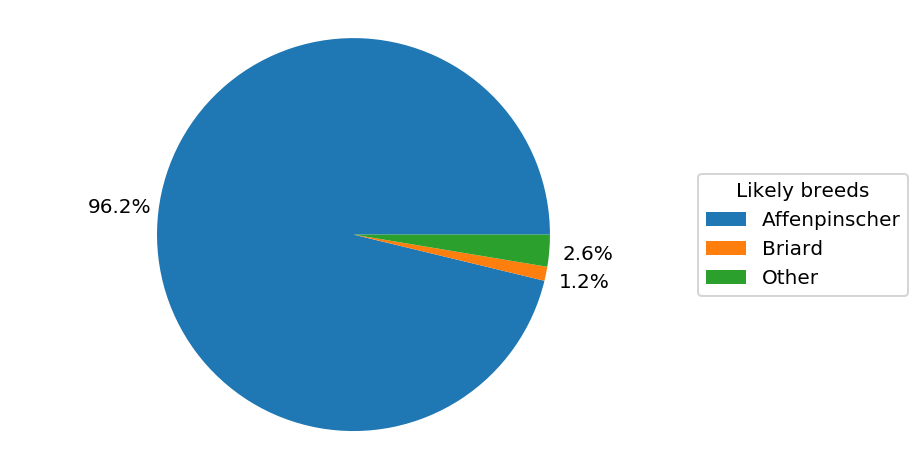

In [112]:
selection = probs > 0.01
# y = x[selection]
# print(class_names[selection])

likely_breeds = [breed for (breed, detected) in zip(class_names, selection) if detected]
likely_probs = [prob for (prob, detected) in zip(probs, selection) if detected]

likely_breeds = likely_breeds + ["Other"]
likely_probs = likely_probs + [1 - sum(likely_probs)]

fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(likely_probs, autopct='%1.1f%%', pctdistance=1.2)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(wedges, likely_breeds, title="Likely breeds", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

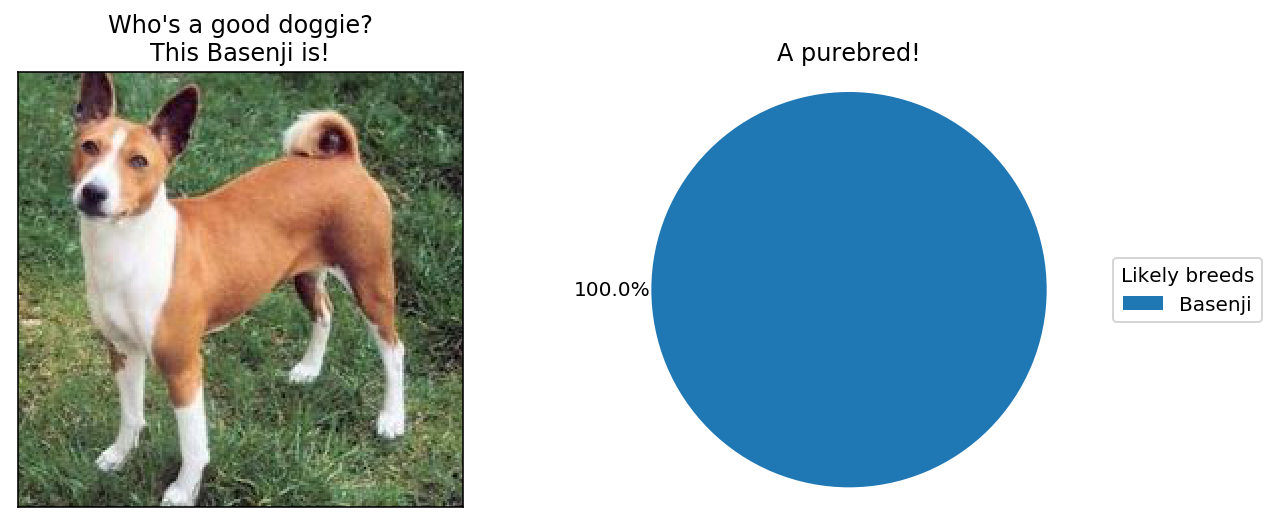

In [141]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

# First make sure we have all the models on the GPU
model_dog_detector = alexnet # Alexnet weirdly turned out to be the best dog detector
model_dog_detector = model_dog_detector.to(device)

def show_image_with_pie(img_path,title_picture,title_pie,likely_breeds,likely_probs):
    # Read the image
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  
    # Show the image
    if title_pie is None:
        fig, ax = plt.subplots(figsize=(12,4))  
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])       
        ax.set_title(title_picture)
    else:
        fig, ax = plt.subplots(1,2,figsize=(10,4))  
        ax[0].imshow(img)
        ax[0].set_xticks([])
        ax[0].set_yticks([])   
        ax[0].set_title(title_picture)
        wedges, texts, autotexts = ax[1].pie(likely_probs, autopct='%1.1f%%', pctdistance=1.2, wedgeprops = {'linewidth': 0})
        ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax[1].legend(wedges, likely_breeds, title="Likely breeds", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))    
        ax[1].set_title(title_pie)
    #     plt.imshow(img)

    #     if title is not None:
    #         plt.gca().set_title(title)
    plt.show()    


def run_app(img_path):
    ## handle cases for a human face, dog, and neither
      
    # Check if a dog is detected
    dog_detected = dog_detector(img_path,model_dog_detector,device)
    # Check if a human is detected
    human_detected = face_detector(img_path)
    # Get the predicted breed(s)
    pred, probs = predict_breed_transfer(img_path, model_transfer, device)
    
    # Let's discard the ones that have a probability of less than 1%
    selection = probs > 0.01
    likely_breeds = [breed for (breed, detected) in zip(class_names, selection) if detected]
    likely_probs = [prob for (prob, detected) in zip(probs, selection) if detected]    
    # And let's fill the discarded gap with "other" (if there is a gap)
    if len(likely_breeds) > 1:
        likely_breeds = likely_breeds + ["Other"]
        likely_probs = likely_probs + [1 - sum(likely_probs)]
    else:
        # If no other breed is predicted with at least 1% let's round up the confidence to 100% (makes the pie chart nicer)
        likely_probs = [100]
        
    # Decide on titles and such
    if dog_detected and not human_detected:
        title_picture = f"Who's a good doggie?\nThis {class_names[pred]} is!"
        if len(likely_breeds) == 1:
            title_pie = "A purebred!"
        else:
            title_pie = "Interesting mix we've got here..."
    elif not dog_detected and human_detected:
        title_picture = f"Hello there!\nYou look like a {class_names[pred]}!"
        title_pie = "Here are all the dog breeds you look like:"        
    elif dog_detected and human_detected:
        title_picture = f"Hello human, that's a nice {class_names[pred]} you've got there!"
        if len(likely_breeds) == 1:
            title_pie = "A purebred!"
        else:
            title_pie = "Interesting mix we've got here..."        
    else:
        title_picture = "That's a nice picture but I can't find any dogs or humans here..."
        title_pie = None
        
    # Show everything
    show_image_with_pie(img_path,title_picture,title_pie,likely_breeds,likely_probs)

run_app(dog_files[100])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

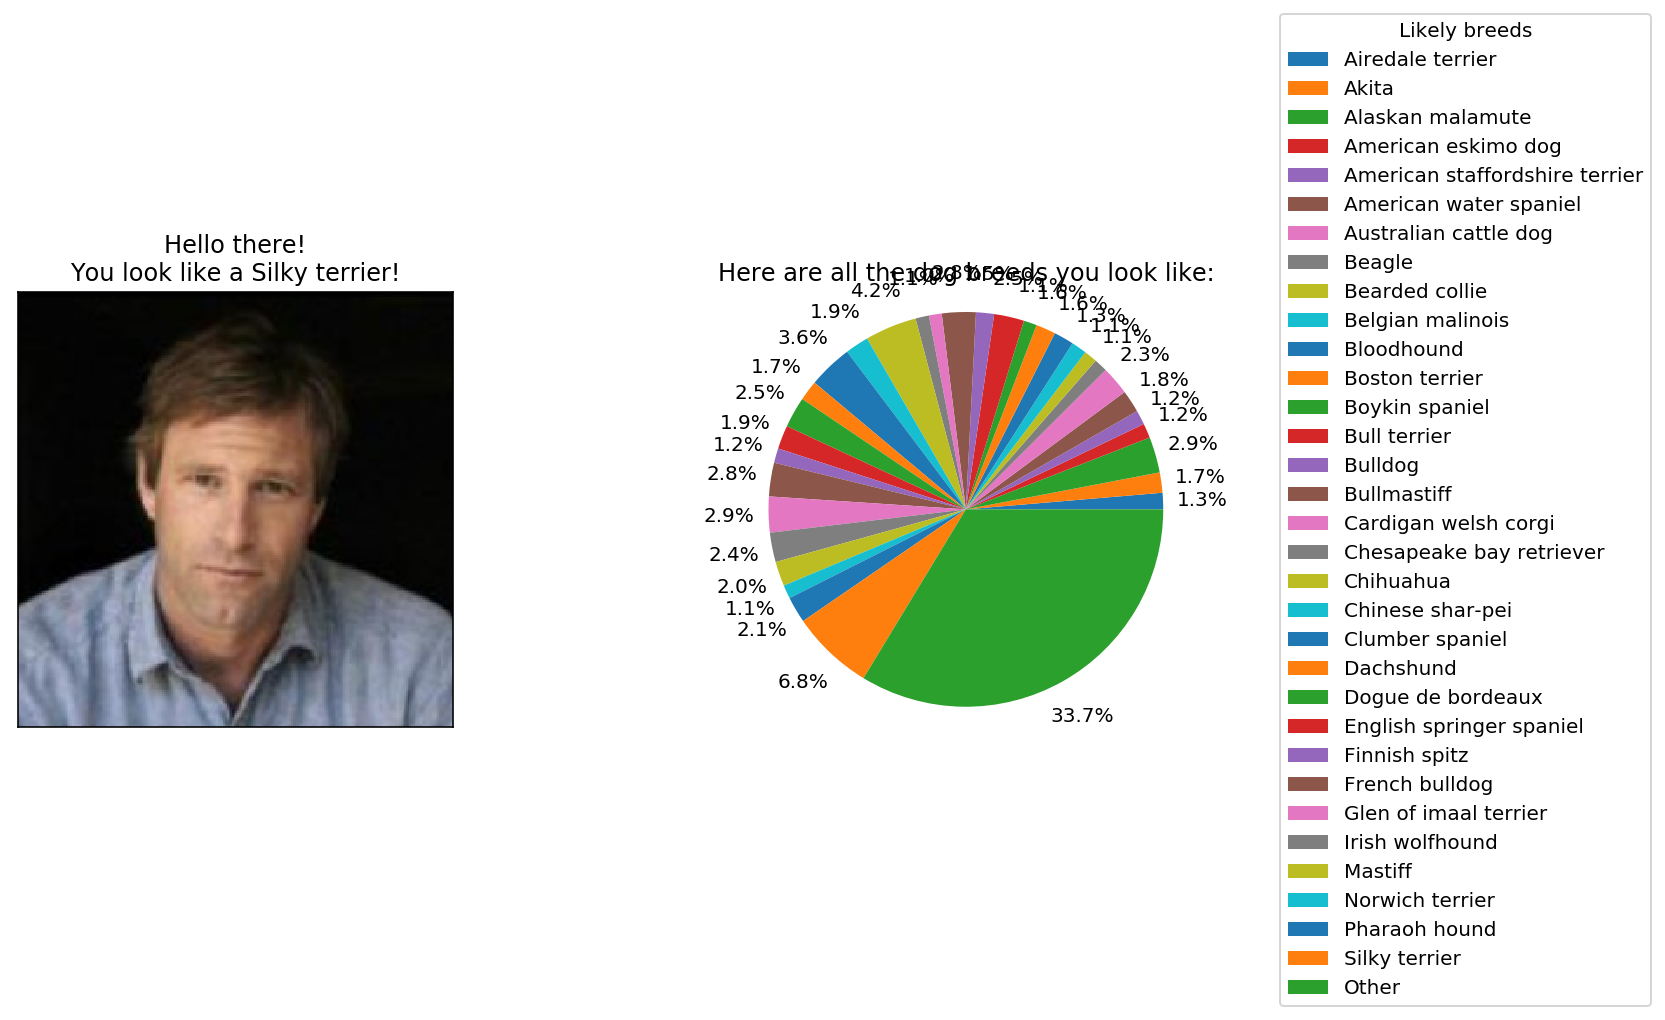

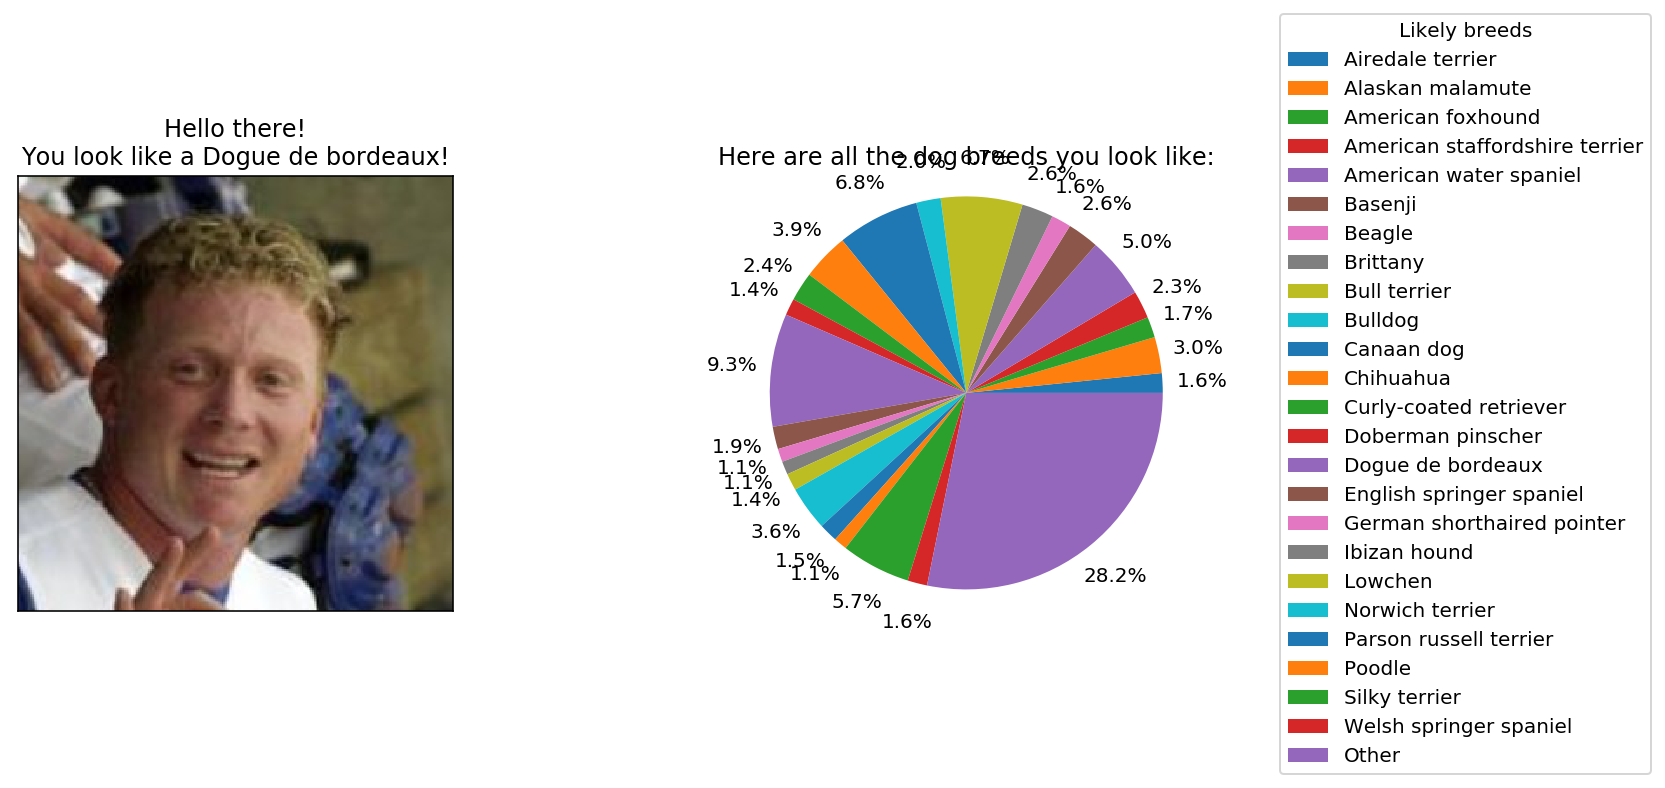

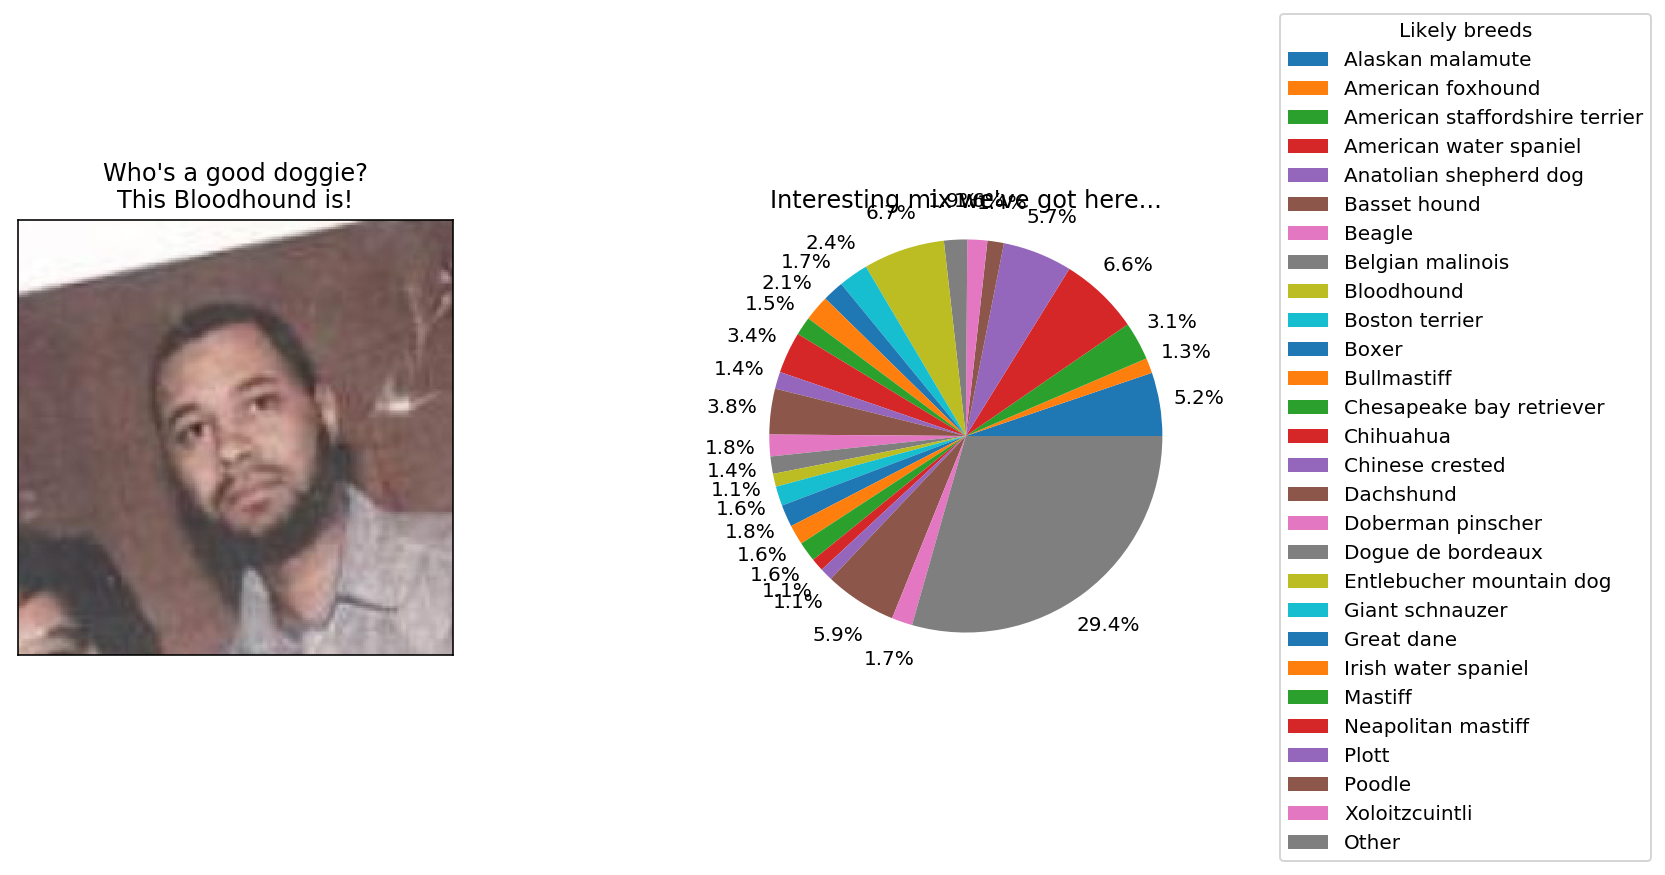

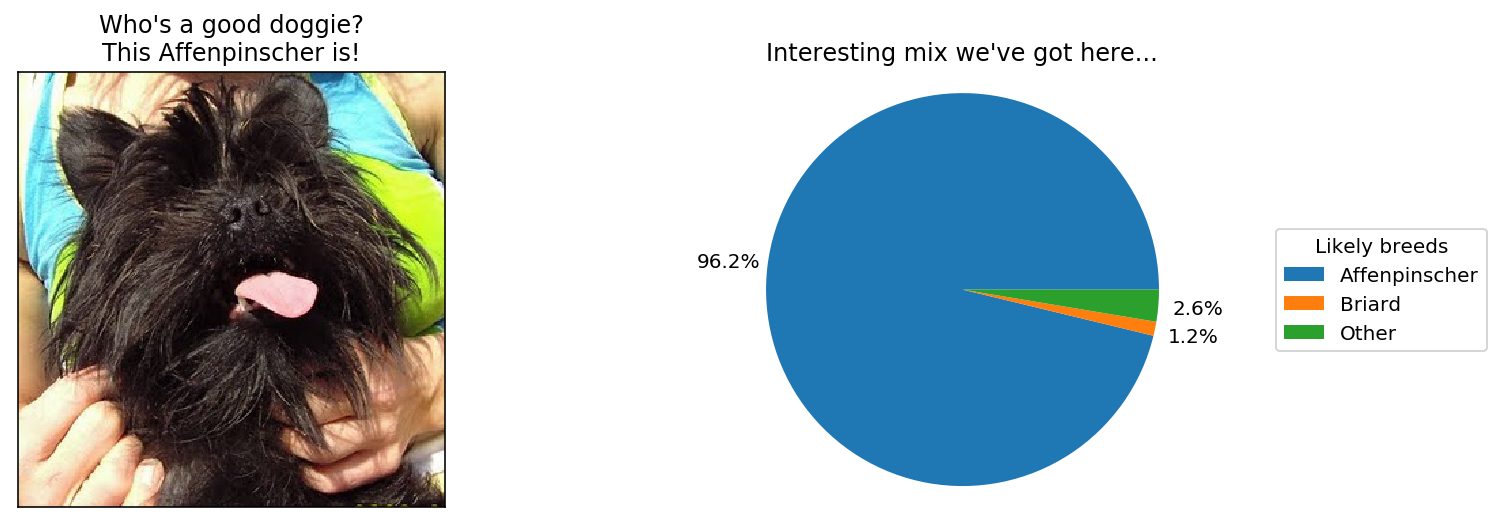

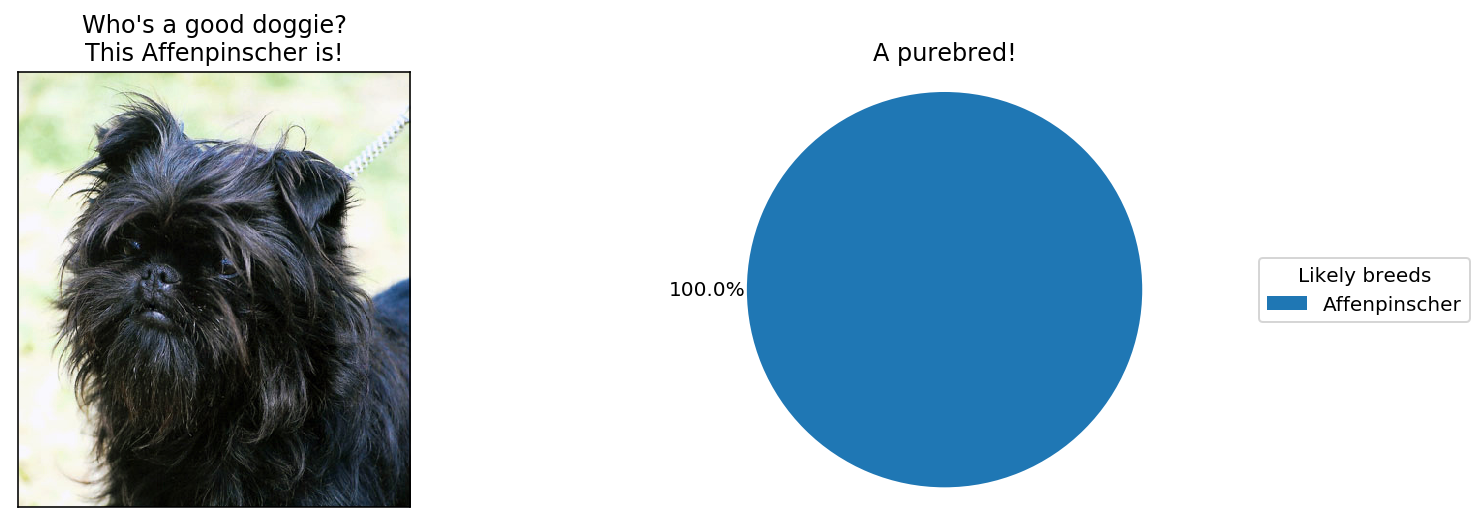

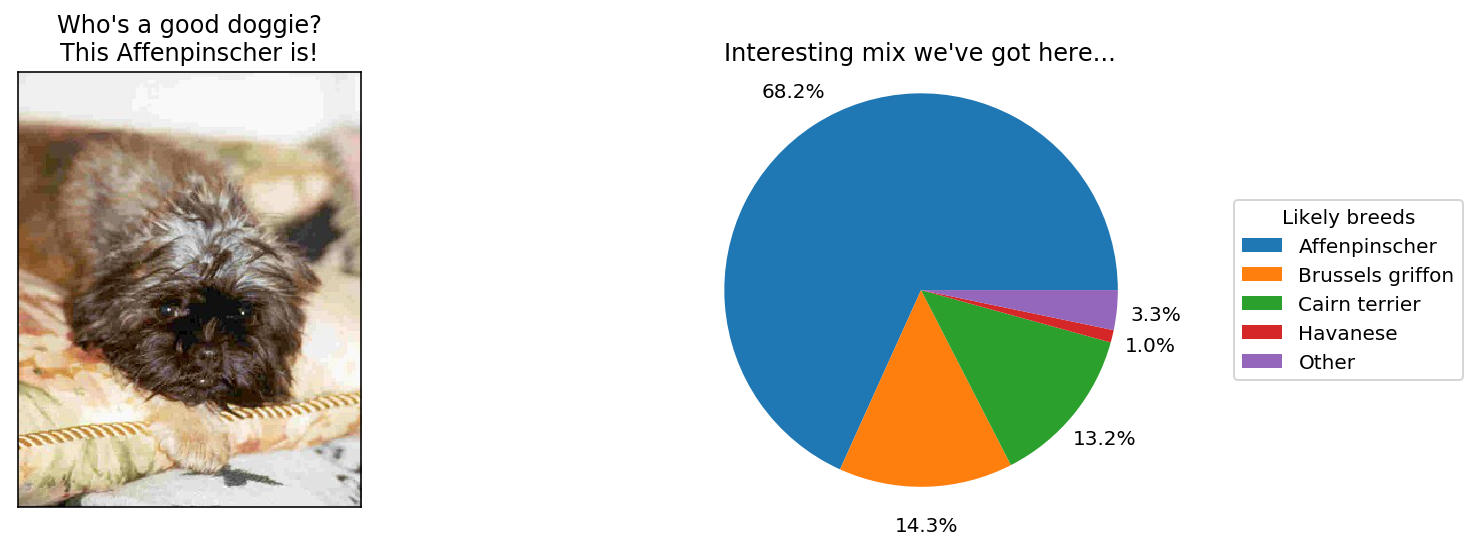

In [139]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)